Copyright (c) András Kalapos. All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.

In [1]:
import wandb
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)

import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

palette  =   ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'] #  plotly.colors.qualitative.Plotly
us_palette = ['#ccd0ff', '#ffd3cc', '#ccfff2', '#e4ccff', '#ffe2cc', '#c2ecf3', '#ffccdb', '#d2e8ba', '#ffccff', '#feefcb'] # colors with 20 %saturation

/home/kaland/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from colorutils import convert as cc

s30_palette = [cc.hsv_to_hex([h, s - 0.3, v]) for h, s, v in [cc.hex_to_hsv(c) for c in palette]]
print(s30_palette)

['#adb3f9', '#ee9282', '#3dcca6', '#d2adf9', '#ffcca6', '#61ddf3', '#ffb2c8', '#d7e8c5', '#ffe3ff', '#fde19e']


In [3]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("YOUR-WANDB-USER-NAME/I-JEPA-CNN")

summary_list, config_list, name_list, run_id_list, tags_list, start_time_list, run_states = [], [], [], [], [], [], []
summary_keys_to_drop = [
]

for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary = run.summary._json_dict
    summary_list.append({k:v for k,v in summary.items() if k not in summary_keys_to_drop})

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    start_time_list.append(run.start_time if hasattr(run, 'start_time') else np.nan) 
    tags_list.append(run.tags)
    run_id_list.append(run.id)  
    run_states.append(run.state)
        

summary_df = pd.DataFrame.from_records(summary_list)
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list, 
                        'tags': tags_list,
                        'id': run_id_list,
                        'state': run_states}) 
runs_df = pd.concat([name_df, config_df,summary_df], axis="columns")

runs_df["_timestamp"] = pd.to_datetime(runs_df["_timestamp"], unit='s')

runs_df["_runtime[h]"] = runs_df["_runtime"]/3600

# Multiply acc scores by 100
runs_df["val_metrics/knn_top1"] = runs_df["val_metrics/knn_top1"] * 100
runs_df["val_metrics/knn_top5"] = runs_df["val_metrics/knn_top5"] * 100
runs_df["val_metrics/lin_top1"] = runs_df["val_metrics/lin_top1"] * 100
runs_df["val_metrics/lin_top5"] = runs_df["val_metrics/lin_top5"] * 100

/home/kaland/.local/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:528: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [5]:
# drop all runs created before June 27th 2024
runs_df = runs_df[runs_df["_timestamp"] >= pd.Timestamp("2024-06-27")]

# drop columns where all values are nan
runs_df = runs_df.dropna(axis=1, how="all")

runs_df

,name,tags,id,state,cfg/name,cfg/seed,cfg/wandb,cfg/mask_ratio,cfg/optimizer/lr,cfg/backbone/name,...,train_metrics/vicreg_loss_epoch,train_metrics/vicreg_loss_step,val_metrics/vicreg_loss,train_metrics/simclr_loss_step,train_metrics/simclr_loss_epoch,val_metrics/simclr_loss,val_metrics/byol_loss,train_metrics/byol_loss_step,train_metrics/byol_loss_epoch,_runtime[h]
0,I-JEPA_imagenet-100_resnet50_IN1kCFG_predL3K3_...,[mask-sweep],hgx79u9x,finished,I-JEPA_imagenet-100_resnet50_IN1kCFG_predL3K3_...,42.0,True,0.6,0.010,resnet50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.935886
1,I-JEPA_imagenet-100_wide_resnet50_2_IN1kCFG_pr...,[],iimqy4wl,finished,I-JEPA_imagenet-100_wide_resnet50_2_IN1kCFG_pr...,42.0,True,0.6,0.010,wide_resnet50_2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.934766
2,I-JEPA_imagenet-100_resnet200_IN1kCFG_predL3K3...,[],vl3pvoet,finished,I-JEPA_imagenet-100_resnet200_IN1kCFG_predL3K3...,42.0,True,0.6,0.010,resnet200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.562620
3,I-JEPA_imagenet-100_resnet152_IN1kCFG_predL3K3...,[],klrmynza,finished,I-JEPA_imagenet-100_resnet152_IN1kCFG_predL3K3...,42.0,True,0.6,0.010,resnet152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.679808
4,imagenet-100vitb14.224-bs.2048-ep.300,[jepa],wndwi9sm,finished,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.876303
5,imagenet-100vits14.224-bs.2048-ep.300,[jepa],u31zo3vo,finished,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.314374
6,VICReg_imagenet-100_resnet50,[],22ryo7p6,finished,VICReg_imagenet-100_resnet50,42.0,True,NaN,0.500,resnet50,...,19.288195,19.367188,21.019426,NaN,NaN,NaN,NaN,NaN,NaN,16.908551
7,SimCLR_imagenet-100_resnet50,[],mzbxo3w6,finished,SimCLR_imagenet-100_resnet50,42.0,True,NaN,1.700,resnet50,...,NaN,NaN,NaN,0.493082,0.493129,1.174373,NaN,NaN,NaN,15.498438
8,I-JEPA_imagenet-1k_resnet50_predL2K3_Mixed_cos...,[predictor-sweep],ha2j8goc,crashed,I-JEPA_imagenet-1k_resnet50_predL2K3_Mixed_cos...,42.0,True,0.6,0.010,resnet50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.818595
9,I-JEPA_imagenet-1k_resnet50_predL2K3_Mixed_cos...,[],n0u96tmk,crashed,I-JEPA_imagenet-1k_resnet50_predL2K3_Mixed_cos...,42.0,True,0.6,0.010,resnet50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.378320


In [5]:
# create a pd dataframe with 3 columns containing the items of runs_df.columns, splitting them into 3 columns
ncols = 4
# pad runs_df.columns to have a multiple of ncols
cols = list(runs_df.columns)
if len(cols) % ncols != 0:
    cols = cols + [""] * (ncols - len(cols)%ncols)

runs_df_cols = pd.DataFrame(np.array(sorted(cols)).reshape(ncols, -1).T)

# display all rows of the dataframe
pd.set_option('display.max_rows', None)
runs_df_cols

,0,1,2,3
0,,cfg/mask/strategy,cfg/use_projection_head,train_metrics/byol_loss_epoch
1,,cfg/mask_ratio,cfg/wandb,train_metrics/byol_loss_step
2,,cfg/name,data,train_metrics/ijepa_loss_epoch
3,_runtime,cfg/optimizer/algorithm,epoch,train_metrics/ijepa_loss_step
4,_runtime[h],cfg/optimizer/batch_size,examples/val_x0_max,train_metrics/lr
5,_step,cfg/optimizer/cosine_warmpup_sched,examples/val_x0_mean,train_metrics/simclr_loss_epoch
6,_timestamp,cfg/optimizer/exclude_norm_and_bias_from_wd,examples/val_x0_min,train_metrics/simclr_loss_step
7,_wandb,cfg/optimizer/lr,id,train_metrics/vicreg_loss_epoch
8,cfg/artifacts_root,cfg/optimizer/lr_warmup_epochs,logging,train_metrics/vicreg_loss_step
9,cfg/backbone/kwargs/global_pool,cfg/optimizer/wd_schedule,mask,train_metrics/wd


## Modify, extend the data

In [6]:
# cast to the correct data types
runs_df["cfg/predictor/kernel_size"] = runs_df["cfg/predictor/kernel_size"].astype(pd.Int64Dtype(), errors="ignore")
runs_df["cfg/predictor/n_layers"] = runs_df["cfg/predictor/n_layers"].astype(pd.Int64Dtype(), errors="ignore")

In [7]:
# Add a column named "algo", if name contains byol, it is byol, if i-jepa, it is i-jepa, else unknown
runs_df["algo"] = "unknown"
runs_df.loc[runs_df["name"].str.contains("BYOL"), "algo"] = "BYOL"
runs_df.loc[runs_df["name"].str.contains("I-JEPA"), "algo"] = "I-JEPA"
runs_df.loc[runs_df["name"].str.contains("SimCLR"), "algo"] = "SimCLR"
runs_df.loc[runs_df["name"].str.contains("VICReg"), "algo"] = "VICReg"
runs_df.loc[runs_df["tags"].apply(lambda x: "jepa" in x), "algo"] = "I-JEPA" # official vit ijepa runs

In [8]:
# Manage config for i-jeppa official runs
runs_df.loc[runs_df["tags"].apply(lambda x: "jepa" in x), "cfg/data/dataset_name"] = "imagenet-100"
runs_df.loc[runs_df["tags"].apply(lambda x: "jepa" in x), "cfg/backbone/name"] = runs_df.loc[runs_df["tags"].apply(lambda x: "jepa" in x), "meta"].apply(lambda x: dict(x)["model_name"])
runs_df.loc[runs_df["tags"].apply(lambda x: "jepa" in x), "cfg/backbone/name"]

4     vit_base
5    vit_small
Name: cfg/backbone/name, dtype: object

In [9]:
# Add a column named "backbone_size"
backbone_sizes = {
    "vit_small": 21.6, # M
    "resnet50": 23.5, # M
    # "resnet152": 58.1, # M
    # "resnet200":  62.6, # M
    "wide_resnet50_2": 66.8, # M
    "vit_base": 85.7, # M
}
# size_order = ["21.6 M", "23.5 M", "85.7 M"]
runs_df["backbone_size"] = runs_df["cfg/backbone/name"].map(backbone_sizes)

runs_df["backbone_type"] = runs_df["cfg/backbone/name"].apply(lambda x: "ViT" if "vit" in x else "CNN")


In [10]:
# some runs run on multi-node 4 gpu, others on single node 4 gpu setup. This is not a fair comparison
# so we take "reference" runs for each algo and dataset and use runtime based on that

reference_run_ids = ["rql7nblf", # BYOL   on imagenet-100
                     "au52nhfx", # I-JEPA on imagenet-100
                     "22ryo7p6", # VICReg on imagenet-100
                     "mzbxo3w6", # SimCLR on imagenet-100
                     "u31zo3vo", # I-JEPA ViT-S on imagenet-100
                     "wndwi9sm", # I-JEPA ViT-B on imagenet-100
                     "0wlmwrd3", # BYOL   on imagenet-1k
                     "f5ip5su8", # I-JEPA on imagenet-1k
                    ]
# the two byols run on
#  an ai node, the two i-jepas run on a gpu node, but we'll just ignore that difference

runs_df['_epoch_time'] = runs_df["_runtime[h]"] / runs_df["epoch"]
reference_runs = runs_df[runs_df["id"].isin(reference_run_ids)].copy()
nominal_runtimes = reference_runs.groupby(["algo", "cfg/data/dataset_name", "cfg/backbone/name"])[["_epoch_time"]].mean()

display(nominal_runtimes)
# set the nominal_runtime for each row according to the dataset and algo
def get_nominal_runtime(row):
    try:
        return nominal_runtimes.loc[row["algo"], row["cfg/data/dataset_name"], row["cfg/backbone/name"]]["_epoch_time"]
    except KeyError:
        return row["_epoch_time"]

runs_df["nominal_runtime_epoch"] = runs_df.apply(get_nominal_runtime, axis=1)

_epoch_time
algo   cfg/data/dataset_name cfg/backbone/name             
BYOL   imagenet-100          resnet50              0.099114
       imagenet-1k           resnet50              1.004694
I-JEPA imagenet-100          resnet50              0.064393
                             vit_base              0.043065
                             vit_small             0.031152
       imagenet-1k           resnet50              0.697050
SimCLR imagenet-100          resnet50              0.077492
VICReg imagenet-100          resnet50              0.084543

In [11]:
# Add display names for columns and some values
cdn = {
    "algo": "Algorithm",
    "backbone_size": "Backbone size [M]",
    "backbone_type": "Backbone type",
    "pred_size": "Predictor size [M]",
    "cfg/data/dataset_name": "Dataset",
    "cfg/backbone/name": "Backbone",
    "cfg/predictor/n_layers": "Predictor layers",
    "cfg/predictor/kernel_size": "Predictor kernel size",
    "cfg/predictor/dw_sep_conv": "Predictor depthwise separable convolution",
    "cfg/mask/strategy": "Masking strategy",
    "val_metrics/lin_top1": "Linear top-1",
    "val_metrics/lin_top5": "Linear top-5",
    "val_metrics/knn_top1": "k-NN top-1",
    "val_metrics/knn_top5": "k-NN top-5",
}
vdn = {
    "imagenet-100": "ImageNet-100",
    "imagenet-1k": "ImageNet-1k",
    "resnet50": "ResNet-50",
    "vit_small": "ViT-Small",
    "vit_base": "ViT-Base",
    "random": "Random",
    "multi-block": "Multi-block",
    "mixed": "Mixed",
}

algo_order = ["SimCLR", "BYOL", "VICReg", "I-JEPA ViT", "I-JEPA"] 
backbone_order = [ "ResNet-50","ViT-Small", "ViT-Base",]

# runs_df = runs_df.rename(columns=cdn)

def map_dict(dictionary, iterable):
    return [dictionary[x]  if x in dictionary else x for x in iterable]


## Tabular results

In [12]:
metrics = ["val_metrics/lin_top1", "val_metrics/knn_top1"]
# reshape the df to have the algo as rows and the dataset and metrics as columns (double header)
runs_df.groupby(["algo", "cfg/backbone/name", "cfg/data/dataset_name"])[metrics].max().unstack(2)

val_metrics/lin_top1              \
cfg/data/dataset_name            imagenet-100 imagenet-1k   
algo   cfg/backbone/name                                    
BYOL   resnet50                     79.020000   60.222000   
I-JEPA resnet152                    76.639998         NaN   
       resnet200                    77.199996         NaN   
       resnet50                     73.259997   54.227996   
       vit_base                     46.359998         NaN   
       vit_small                    42.299998         NaN   
       wide_resnet50_2              76.139998         NaN   
SimCLR resnet50                     76.199996         NaN   
VICReg resnet50                     74.180001         NaN   

                         val_metrics/knn_top1              
cfg/data/dataset_name            imagenet-100 imagenet-1k  
algo   cfg/backbone/name                                   
BYOL   resnet50                     68.199998   45.378000  
I-JEPA resnet152                    61.119998         NaN  
       resnet200                    61.519998         NaN  
       resnet50                     59.219998   35.343999  
       vit_base                     31.360000         NaN  
       vit_small                    34.840000         NaN  
       wide_resnet50_2              62.400001         NaN  
SimCLR resnet50                     67.259997         NaN  
VICReg resnet50                     64.319998         NaN

In [13]:
# Pretty version
display_df = runs_df.rename(columns=cdn)

metrics = ["val_metrics/lin_top1", "val_metrics/knn_top1"]
metrics = map_dict(cdn, metrics)
# reshape the df to have the algo as rows and the dataset and metrics as columns (double header)
res = display_df.groupby(map_dict(cdn,["cfg/backbone/name","algo",  "cfg/data/dataset_name"]))[metrics].max().unstack(2).swaplevel(0,1, axis=1).sort_index(axis=1)

res.rename(columns=vdn, inplace=True)
res.replace(vdn, inplace=True) # replaces values in the table
res.rename(vdn, inplace=True) # replaces names in the index
res = res.reindex(algo_order, level=1)
res = res.reindex(backbone_order, level=0)

## Benchmark in-1k results
# VICReg
#   lin_top1: 59.83%                  
#   knn_top1: 46.82%
# SimCLR
#   lin_top1: 59.81%
#   knn_top1: 45.31%      

style = res.style
# display precision of 2 digits
style.format("{:.2f}")
display(style)

latex = style.to_latex(
    column_format="rrcccc", position="tbp", position_float="centering",
    hrules=True, label="table:main_results", caption="Linear and k-NN top-1 accuracies for different algorithms and backbones on ImageNet-1k and ImageNet-100 datasets.",
    multirow_align="c", multicol_align="c", convert_css=True
)
latex = latex.replace("nan" ,"-")

print(latex)

\begin{table}[tbp]
\centering
\caption{Linear and k-NN top-1 accuracies for different algorithms and backbones on ImageNet-1k and ImageNet-100 datasets.}
\label{table:main_results}
\begin{tabular}{rrcccc}
\toprule
{} & {Dataset} & \multicolumn{2}{c}{ImageNet-100} & \multicolumn{2}{c}{ImageNet-1k} \\
{} & {} & {Linear top-1} & {k-NN top-1} & {Linear top-1} & {k-NN top-1} \\
{Backbone} & {Algorithm} & {} & {} & {} & {} \\
\midrule
\multirow[c]{4}{*}{ResNet-50} & SimCLR & 76.20 & 67.26 & - & - \\
 & BYOL & 79.02 & 68.20 & 60.22 & 45.38 \\
 & VICReg & 74.18 & 64.32 & - & - \\
 & I-JEPA & 73.26 & 59.22 & 54.23 & 35.34 \\
ViT-Small & I-JEPA & 42.30 & 34.84 & - & - \\
ViT-Base & I-JEPA & 46.36 & 31.36 & - & - \\
\bottomrule
\end{tabular}
\end{table}



**TODO**: Add more algorithms..., maybe also add STL-10

## Compute budget vs accuracy plots

In [14]:
import seaborn.objects as so # https://seaborn.pydata.org/tutorial/objects_interface.html
from seaborn import axes_style
from seaborn import plotting_context

theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}
theme_dict["xtick.bottom"] = True
theme_dict["ytick.left"] = True
theme_dict['font.family'] = 'serif'

,Algorithm,Dataset,Backbone,Linear top-1,Training cost (GPU hours),epoch,nominal_runtime_epoch
23,BYOL,imagenet-100,resnet50,79.020000,79.291127,200.0,0.099114
32,CNN-JEPA (Ours),imagenet-100,resnet50,73.259997,51.514766,200.0,0.064393
1,CNN-JEPA (Ours),imagenet-100,wide_resnet50_2,76.139998,63.739064,200.0,0.079674
4,I-JEPA ViT,imagenet-100,vit_base,46.359998,51.505214,299.0,0.043065
5,I-JEPA ViT,imagenet-100,vit_small,42.299998,37.257496,299.0,0.031152
7,SimCLR,imagenet-100,resnet50,76.199996,61.993752,200.0,0.077492
6,VICReg,imagenet-100,resnet50,74.180001,67.634205,200.0,0.084543


/home/kaland/miniconda3/envs/nb/lib/python3.9/site-packages/seaborn/_core/properties.py:130: UserWarning: The color list has more values (10) than needed (5), which may not be intended.
  warnings.warn(message, UserWarning)


/home/kaland/miniconda3/envs/nb/lib/python3.9/site-packages/seaborn/_core/properties.py:130: UserWarning: The color list has more values (10) than needed (5), which may not be intended.
  warnings.warn(message, UserWarning)


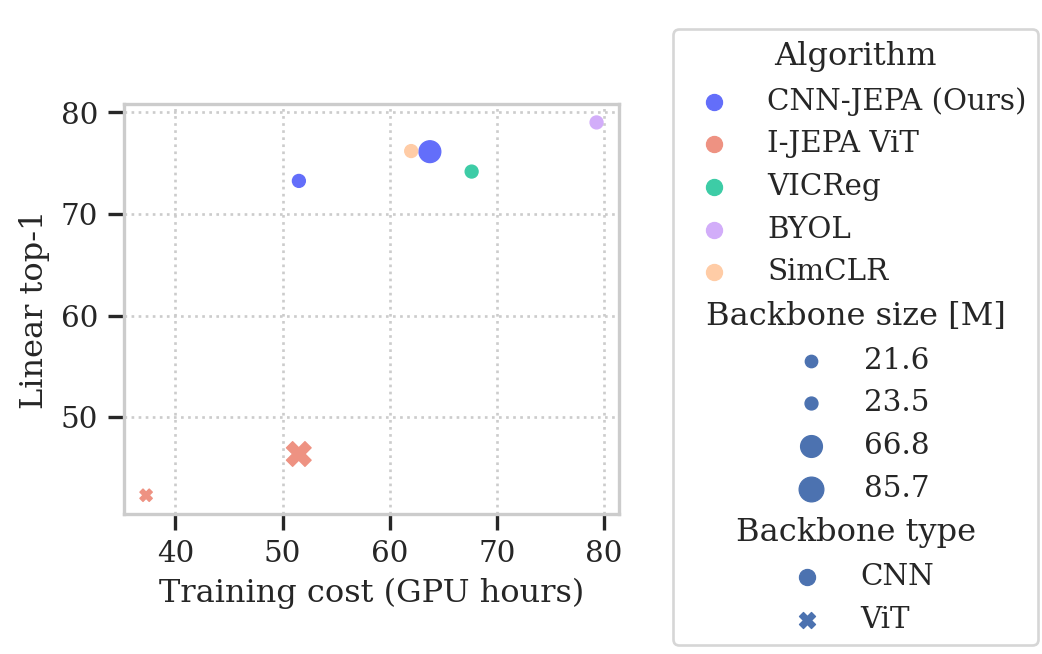

In [15]:
filtered_df = runs_df.copy()
filtered_df = filtered_df[filtered_df['cfg/data/dataset_name'] == 'imagenet-100']
filtered_df = filtered_df[~filtered_df['cfg/backbone/name'].isin(["resnet152", "resnet200"])]

filtered_df.loc[(filtered_df["algo"] == "I-JEPA") & (filtered_df["cfg/backbone/name"].str.contains("vit")), "algo"] = "I-JEPA ViT"

# for each algoritm, dataset select the run with the highest lin_top1
filtered_df = filtered_df.loc[filtered_df.groupby(["algo", "cfg/data/dataset_name", "cfg/backbone/name"])["val_metrics/lin_top1"].idxmax()]
filtered_df["Training cost (GPU hours)"] = filtered_df["nominal_runtime_epoch"]*filtered_df["epoch"] * 4 # 4 gpus

filtered_df.rename(columns=cdn, inplace=True)
filtered_df.replace({"I-JEPA": "CNN-JEPA (Ours)"}, inplace=True)
plot_algo_order = [a if a != "I-JEPA" else "CNN-JEPA (Ours)" for a in algo_order][::-1]
plot_palette = [palette[0]] + s30_palette[1:]

display(filtered_df[map_dict(cdn,["algo", "cfg/data/dataset_name", "cfg/backbone/name", "val_metrics/lin_top1", "Training cost (GPU hours)", 'epoch', 'nominal_runtime_epoch'])])

(
    so.Plot(filtered_df, x="Training cost (GPU hours)", y=cdn["val_metrics/lin_top1"], color=cdn["algo"], pointsize=cdn['backbone_size'], marker=cdn["backbone_type"])
    .add(so.Dot())
    # .facet(col="cfg/data/dataset_name", )
    .share(x=False)
    .scale(color=so.Nominal(plot_palette, order=plot_algo_order),
           pointsize=so.Nominal([np.sqrt(x) for x in backbone_sizes.values()])
    )
    .theme(theme_dict)
    .layout(size=(3.5,3), engine="tight")
    .save("training_cost_vs_lin_top1.pdf", transparent=True, bbox_inches="tight", dpi=450)
)

/home/kaland/miniconda3/envs/nb/lib/python3.9/site-packages/seaborn/_core/properties.py:130: UserWarning: The color list has more values (10) than needed (5), which may not be intended.
  warnings.warn(message, UserWarning)
/home/kaland/miniconda3/envs/nb/lib/python3.9/site-packages/seaborn/_core/properties.py:130: UserWarning: The color list has more values (10) than needed (5), which may not be intended.
  warnings.warn(message, UserWarning)


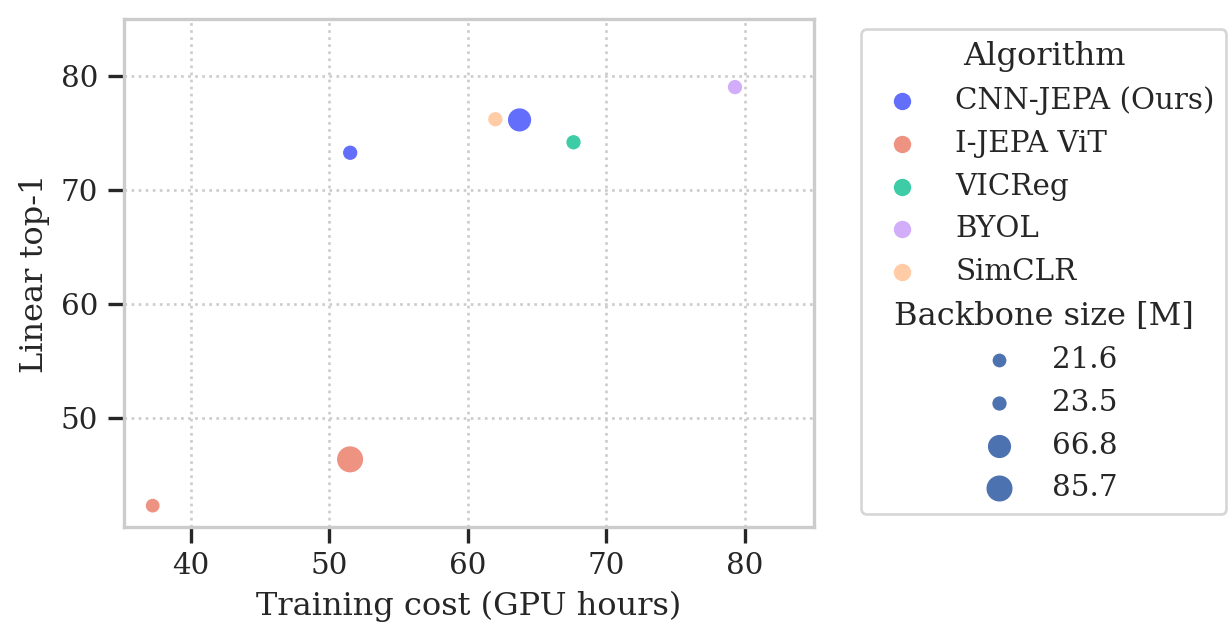

In [16]:
(
    so.Plot(filtered_df, x="Training cost (GPU hours)", y=cdn["val_metrics/lin_top1"], color=cdn["algo"], pointsize=cdn['backbone_size'], )
    .add(so.Dot())
    # .facet(col="cfg/data/dataset_name", )
    .share(x=False)
    .scale(
        color=so.Nominal(plot_palette, order=plot_algo_order),
        pointsize=so.Nominal([np.sqrt(x) for x in backbone_sizes.values()])
    )
    .limit(x=(None,85), y=(None,85))
    .theme(theme_dict)
    .layout(size=(4.5, 3.5), engine="tight")
    .save("training_cost_vs_lin_top1_2.pdf", transparent=True, bbox_inches="tight", dpi=450)
)

## Predictor ablation

In [17]:
filtered_df = runs_df[runs_df['tags'].apply(lambda x: 'predictor-sweep' in x)]
filtered_df = filtered_df[filtered_df['cfg/data/dataset_name'] == 'imagenet-100']
filtered_df = filtered_df[filtered_df['cfg/predictor/dw_sep_conv'] == True]
filtered_df = filtered_df[filtered_df['cfg/predictor/n_layers'] == 3]

filtered_df.loc[filtered_df['cfg/predictor/kernel_size'] == 3, 'pred_size'] = '12.7 M'
filtered_df.loc[filtered_df['cfg/predictor/kernel_size'] == 5, 'pred_size'] = '12.8 M'
filtered_df.loc[filtered_df['cfg/predictor/kernel_size'] == 7, 'pred_size'] = '12.9 M'
filtered_df.loc[filtered_df['cfg/predictor/kernel_size'] == 9, 'pred_size'] = '13.1 M'

filtered_df.rename(columns=cdn, inplace=True)

res = filtered_df.groupby(map_dict(cdn,['cfg/predictor/kernel_size',]))[map_dict(cdn, ['val_metrics/lin_top1', 'val_metrics/knn_top1','pred_size'])].max()

style = res.style
# display precision of 2 digits
style.format(precision=2)
display(style)

latex = style.to_latex(
    column_format="rrcccc", position="tbp", position_float="centering",
    hrules=True, label="tab:pred_kernel_size", caption="Predictor kernel size ablation on ImageNet-100.",
    multirow_align="c", multicol_align="c", convert_css=True
)
latex = latex.replace("nan" ,"-")

print(latex)

,Linear top-1,k-NN top-1,Predictor size [M]
Predictor kernel size,,,
3,73.26,56.26,12.7 M
5,73.08,54.88,12.8 M
7,72.44,53.76,12.9 M
9,73.16,53.46,13.1 M


\begin{table}[tbp]
\centering
\caption{Predictor kernel size ablation on ImageNet-100.}
\label{tab:pred_kernel_size}
\begin{tabular}{rrcccc}
\toprule
{} & {Linear top-1} & {k-NN top-1} & {Predictor size [M]} \\
{Predictor kernel size} & {} & {} & {} \\
\midrule
3 & 73.26 & 56.26 & 12.7 M \\
5 & 73.08 & 54.88 & 12.8 M \\
7 & 72.44 & 53.76 & 12.9 M \\
9 & 73.16 & 53.46 & 13.1 M \\
\bottomrule
\end{tabular}
\end{table}



In [18]:
filtered_df = runs_df[runs_df['tags'].apply(lambda x: 'predictor-sweep' in x)].copy()
filtered_df = filtered_df[filtered_df['cfg/predictor/dw_sep_conv'] == True]
filtered_df = filtered_df[(filtered_df['cfg/predictor/kernel_size'] == 3) | (filtered_df['id'] == 'k43yw88w')]

filtered_df.loc[filtered_df['cfg/predictor/n_layers'] == 1, 'pred_size'] = '4.2 M'
filtered_df.loc[filtered_df['cfg/predictor/n_layers'] == 2, 'pred_size'] = '8.4 M'
filtered_df.loc[filtered_df['cfg/predictor/n_layers'] == 3, 'pred_size'] = '12.7 M'
filtered_df.loc[filtered_df['cfg/predictor/n_layers'] == 4, 'pred_size'] = '16.9 M'
filtered_df.loc[filtered_df['cfg/predictor/n_layers'] == 5, 'pred_size'] = '21.1 M'
filtered_df.loc[filtered_df['cfg/predictor/n_layers'] == 6, 'pred_size'] = '25.3 M'

filtered_df.rename(columns=cdn, inplace=True)
filtered_df.replace(vdn, inplace=True)

res = filtered_df.groupby(map_dict(cdn,['cfg/data/dataset_name','cfg/predictor/n_layers']))[map_dict(cdn,['val_metrics/lin_top1', 'val_metrics/knn_top1', 'pred_size'])].max()

style = res.style
# display precision of 2 digits
style.format(precision=2)
display(style)

latex = style.to_latex(
    column_format="rrcccc", position="tbp", position_float="centering",
    hrules=True, label="tab:pred_depth", caption="Predictor depth ablation on ImageNet-100 and ImageNet-1k.",
    multirow_align="c", multicol_align="c", convert_css=True
)
latex = latex.replace("nan" ,"-")
latex = latex.replace("\\\n\multirow", "\\\n\midrule\n\multirow")


print(latex)

\begin{table}[tbp]
\centering
\caption{Predictor depth ablation on ImageNet-100 and ImageNet-1k.}
\label{tab:pred_depth}
\begin{tabular}{rrcccc}
\toprule
{} & {} & {Linear top-1} & {k-NN top-1} & {Predictor size [M]} \\
{Dataset} & {Predictor layers} & {} & {} & {} \\
\midrule
\multirow[c]{6}{*}{ImageNet-100} & 1 & 64.86 & 51.84 & 4.2 M \\
 & 2 & 73.22 & 59.22 & 8.4 M \\
 & 3 & 73.26 & 56.26 & 12.7 M \\
 & 4 & 71.72 & 53.84 & 16.9 M \\
 & 5 & 71.14 & 50.94 & 21.1 M \\
 & 6 & 69.24 & 47.68 & 25.3 M \\
\midrule
\multirow[c]{2}{*}{ImageNet-1k} & 2 & 49.78 & 31.96 & 8.4 M \\
 & 3 & 54.23 & 35.00 & 12.7 M \\
\bottomrule
\end{tabular}
\end{table}



In [19]:
filtered_df = runs_df[runs_df['tags'].apply(lambda x: 'predictor-sweep' in x)]
filtered_df = filtered_df[(filtered_df['cfg/predictor/kernel_size'] == 3)
                          & (filtered_df['cfg/predictor/n_layers'] == 3)]

filtered_df["Training cost (GPU hours)"] = filtered_df["_runtime[h]"] * 4 # 4 gpus

filtered_df.loc[filtered_df['cfg/predictor/dw_sep_conv'] == True, 'pred_size'] = '113 M'
filtered_df.loc[filtered_df['cfg/predictor/dw_sep_conv'] == False, 'pred_size'] = '12.7 M'
"""
dw_sep_conv == True
  | Name                     | Type       | Params
--------------------------------------------------------
0 | backbone                 | ResNet     | 23.5 M
1 | backbone_for_online_eval | ResNet     | 23.5 M
2 | predictor                | Sequential | 12.7 M
--------------------------------------------------------

dw_sep_conv == False
  | Name                     | Type       | Params
--------------------------------------------------------
0 | backbone                 | ResNet     | 23.5 M
1 | backbone_for_online_eval | ResNet     | 23.5 M
2 | predictor                | Sequential | 113 M
--------------------------------------------------------
"""

filtered_df.rename(columns=cdn, inplace=True)
filtered_df.replace(vdn, inplace=True)

res = filtered_df.groupby(cdn['cfg/predictor/dw_sep_conv'])[map_dict(cdn,['val_metrics/lin_top1', 'val_metrics/knn_top1', 'pred_size', 'Training cost (GPU hours)'])].max()

style = res.style
# display precision of 2 digits
style.format(precision=2)
display(style)

latex = style.to_latex(
    column_format="rrcccc", position="tbp", position_float="centering",
    hrules=True, label="tab:pred_dw_conv", caption="Ablation on using depthwise separable convolution in the predictor on ImageNet-100.",
    multirow_align="c", multicol_align="c", convert_css=True
)


print(latex)

,Linear top-1,k-NN top-1,Predictor size [M],Training cost (GPU hours)
Predictor depthwise separable convolution,,,,
False,72.64,54.76,12.7 M,62.07
True,73.26,56.26,113 M,51.51


\begin{table}[tbp]
\centering
\caption{Ablation on using depthwise separable convolution in the predictor on ImageNet-100.}
\label{tab:pred_dw_conv}
\begin{tabular}{rrcccc}
\toprule
{} & {Linear top-1} & {k-NN top-1} & {Predictor size [M]} & {Training cost (GPU hours)} \\
{Predictor depthwise separable convolution} & {} & {} & {} & {} \\
\midrule
False & 72.64 & 54.76 & 12.7 M & 62.07 \\
True & 73.26 & 56.26 & 113 M & 51.51 \\
\bottomrule
\end{tabular}
\end{table}



## Masking ablation

In [20]:
filtered_df = runs_df[runs_df['tags'].apply(lambda x: 'mask-sweep' in x)]

filtered_df.rename(columns=cdn, inplace=True)
filtered_df.replace(vdn, inplace=True)

res = filtered_df.groupby([cdn['cfg/mask/strategy']])[map_dict(cdn,['val_metrics/lin_top1', 'val_metrics/knn_top1'])].max()

style = res.style
# display precision of 2 digits
style.format(precision=2)
display(style)

latex = style.to_latex(
    column_format="rrcccc", position="tbp", position_float="centering",
    hrules=True, label="tab:masking", caption="Ablation on masking strategies on ImageNet-100.",
    multirow_align="c", multicol_align="c", convert_css=True
)


print(latex)

/home/kaland/.local/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/kaland/.local/lib/python3.9/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Linear top-1,k-NN top-1
Masking strategy,,
Mixed,73.26,56.26
Multi-block,73.02,55.62
Random,57.64,36.64


\begin{table}[tbp]
\centering
\caption{Ablation on masking strategies on ImageNet-100.}
\label{tab:masking}
\begin{tabular}{rrcccc}
\toprule
{} & {Linear top-1} & {k-NN top-1} \\
{Masking strategy} & {} & {} \\
\midrule
Mixed & 73.26 & 56.26 \\
Multi-block & 73.02 & 55.62 \\
Random & 57.64 & 36.64 \\
\bottomrule
\end{tabular}
\end{table}

